# Multi-Pixel Photon Counter simulation for the CBM experiment

This script simulates a MPPC response integrating dark count rate, crosstalk and afterpulsing. This study is made for the CBM (Compressed Baryonic Matter) experiment.

Jesus Peña-Rodriguez,
Bergische Universität Wuppertal

In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

In [2]:
# DCR, Crosstalk, Afterpulsing pixel model
def Pixel (DCR, Pixel_size, Cross, After, W): # DCR(Hz/mm2), pixel size(mm2), Crosstalk(%), Afterpulsing(%), recording window(ns)

    # Pulse shape
    
    Cj = 20e-12
    Rs = 10
    RQ = 50

    t_pulse = np.linspace(0,10,10)*1e-9
    N = len(t_pulse)
    Pulse = np.zeros(N)

    A = 1
    t1 = 1e-9

    for i in range (N):
        if t_pulse[i] < t1:
            Pulse[i] = A*(1-np.exp(-t_pulse[i]/(Rs*Cj)))
        else:
            Pulse[i] = A*np.exp((t1-t_pulse[i])/(RQ*Cj))
        
    DCR_pixel = DCR*Pixel_size
    Tau = 1/DCR_pixel
    F_after = After*DCR_pixel
    Tau_after = 1/F_after

    # Adding afterpulsing

    DCR_impulses = np.zeros(W)
    Cross_impulses = np.zeros(W)
    After_impulses = np.zeros(W)
    DCR_Cross_After_pulses = np.zeros(W)
    index = 0

    while index < W-N:
        Rt = np.random.exponential(scale=Tau, size=None)*1e9
        index = index + int(Rt)
        if index >= W-N:
            break
            
        if np.random.uniform() < Cross: # Crosstalk probability
            Cross_impulses[index] = 2
            DCR_Cross_After_pulses[index:index+N] = DCR_Cross_After_pulses[index:index+N] + 2*Pulse

        else:
            DCR_impulses[index] = 1
            DCR_Cross_After_pulses[index:index+N] = DCR_Cross_After_pulses[index:index+N] + Pulse

        if np.random.uniform() < After: # Afterpulse probability
            Rt_after = int(np.random.exponential(scale=Tau_after, size=None)*1e9)

            if index+Rt_after > W-N:
                break
            After_impulses[index+Rt_after] = 1
            DCR_Cross_After_pulses[index+Rt_after:index+Rt_after+N] = DCR_Cross_After_pulses[index+Rt_after:index+Rt_after+N] + Pulse

        
    return DCR_Cross_After_pulses

## Pulse shape

In [3]:
Cj = 20e-12
Rs = 10
RQ = 50

t_pulse = np.linspace(0,10,10)*1e-9
N = len(t_pulse)
Pulse = np.zeros(N)

A = 1.1
t1 = 1e-9

for i in range (N):
    if t_pulse[i] < t1:
        Pulse[i] = A*(1-np.exp(-t_pulse[i]/(Rs*Cj)))
    else:
        Pulse[i] = A*np.exp((t1-t_pulse[i])/(RQ*Cj))


Text(0, 1.0, 'Amplitude [mV]')

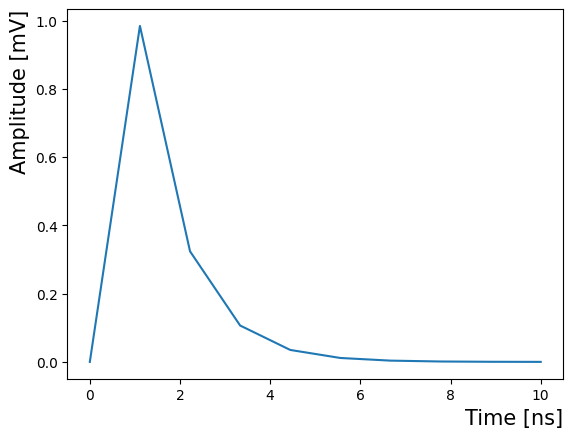

In [4]:
plt.figure()
plt.plot(t_pulse*1e9, Pulse)
plt.xlabel("Time [ns]", horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel('Amplitude [mV]', horizontalalignment='right', y=1.0, fontsize=15)

## MPPC model

In [30]:
M = 8 # M x M array szie
N_pixel = M*M

DCR = 100e3  # Hz/mm2
Pixel_size = 36 # mm2
Cross = 0.25 # %
After = 0.08 # %
W = 1000000 # Recording window

Array_signal = np.zeros((N_pixel,W))

for i in range(N_pixel):
    Array_signal[i,:] = Pixel(DCR, Pixel_size, Cross, After, W)
        

In [31]:
T0 = 4500 # Detection time
Window = 10

# Evaluation window (ns)
Trigger = np.max(Pulse) # Trigger level

Array_pixel = np.zeros(N_pixel)

for i in range(N_pixel):
    if np.max(Array_signal[i,T0:T0+Window]) >= Trigger:
        Array_pixel[i] = 1
Array = np.reshape(Array_pixel, (M, M))

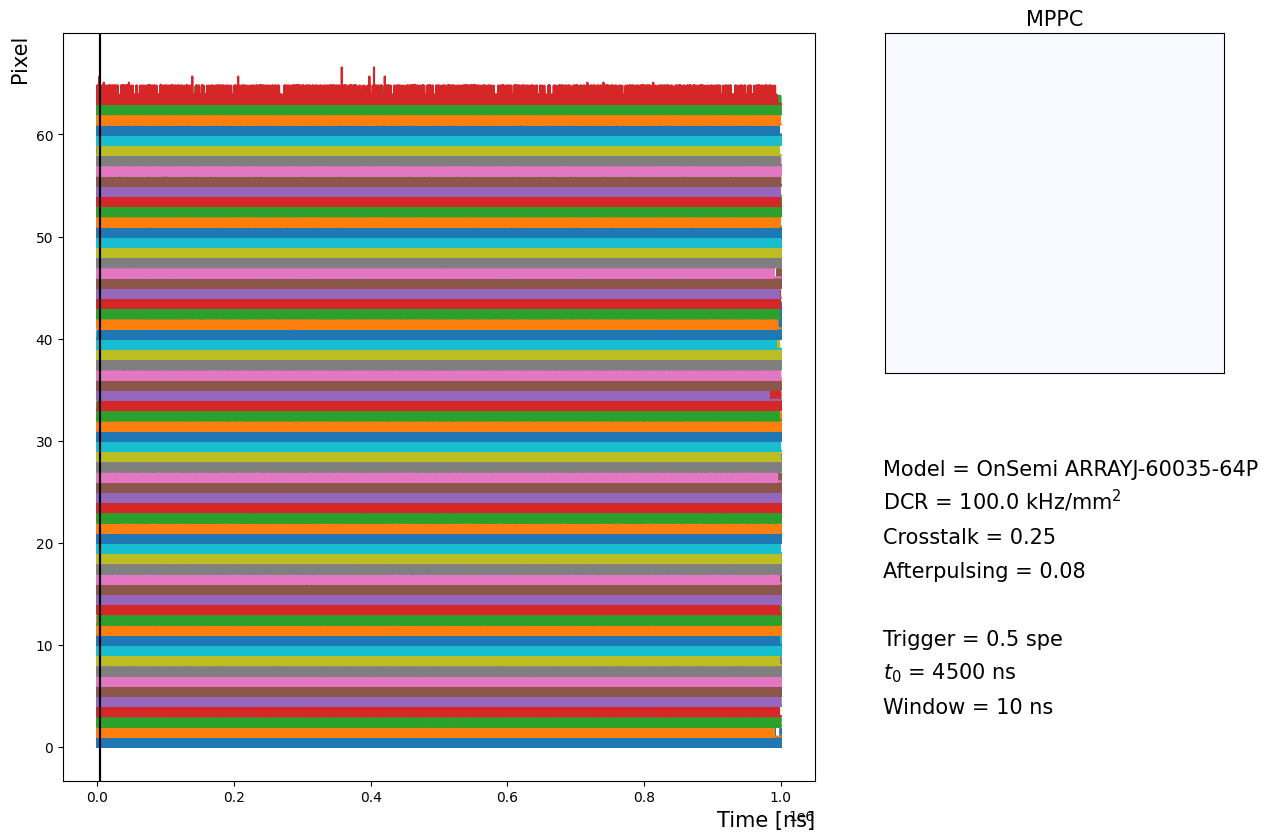

In [32]:
fig = plt.figure(figsize=(15, 15))

plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=2)
for i in range(N_pixel):
    plt.plot(Array_signal[i,:]+i)
plt.axvline(x = T0, color = 'k')
plt.axvline(x = T0+Window, color = 'k')
plt.xlabel("Time [ns]", horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel("Pixel", horizontalalignment='right', y=1.0, fontsize=15)

plt.subplot2grid((3,3), (0,2), rowspan=1)
plt.imshow(Array, cmap='Blues')
plt.xticks([])
plt.yticks([])
plt.title("MPPC", fontsize=15)

plt.subplot2grid((3,3), (1,2), rowspan=1)
plt.text(0,0.9,"Model = OnSemi ARRAYJ-60035-64P", fontsize=15)
plt.text(0,0.8,"DCR = " + str(DCR/1e3) + " kHz/mm$^2$", fontsize=15)
plt.text(0,0.7,"Crosstalk = " + str(Cross), fontsize=15)
plt.text(0,0.6,"Afterpulsing = " + str(After), fontsize=15)
plt.text(0,0.4,"Trigger = 0.5 spe", fontsize=15)
plt.text(0,0.3,"$t_0$ = " + str(T0) + " ns", fontsize=15)
plt.text(0,0.2,"Window = " + str(Window) + " ns", fontsize=15)
plt.xticks([])
plt.yticks([])
plt.axis("off")

#plt.savefig("Figures/OnSemi_long_low.eps",bbox_inches='tight')

plt.show()

0.4079054863656511

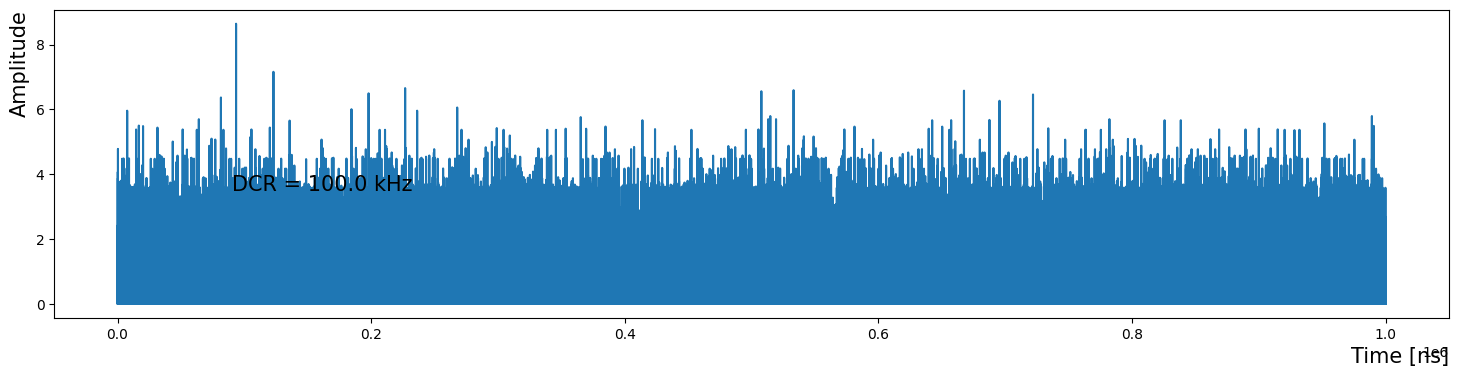

In [33]:
sum = np.sum(Array_signal, axis=0)
plt.figure(figsize=(18, 4))
plt.plot(sum)
plt.xlabel("Time [ns]", horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel("Amplitude", horizontalalignment='right', y=1.0, fontsize=15)
plt.text(9e4,3.5,"DCR = " + str(DCR/1e3) + " kHz", fontsize=15)
#plt.savefig("Figures/OnSemi_pixel_low.eps",bbox_inches='tight')

np.mean(sum)

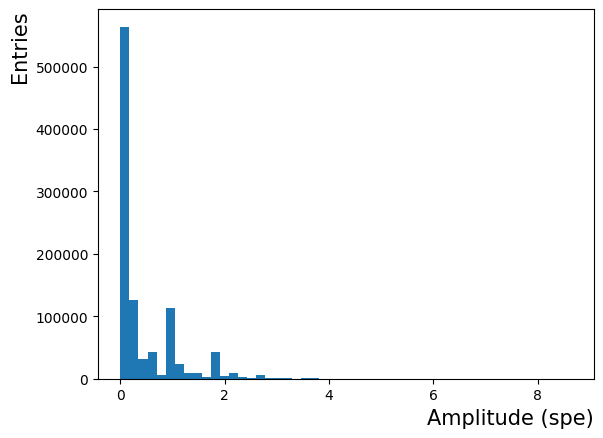

In [34]:
plt.figure()
plt.hist(sum, bins=50)
plt.xlabel("Amplitude (spe)", horizontalalignment='right', x=1.0, fontsize=15)
plt.ylabel("Entries", horizontalalignment='right', y=1.0, fontsize=15)

#plt.savefig("Figures/OnSemi_spectrum_low.eps",bbox_inches='tight')

plt.show()

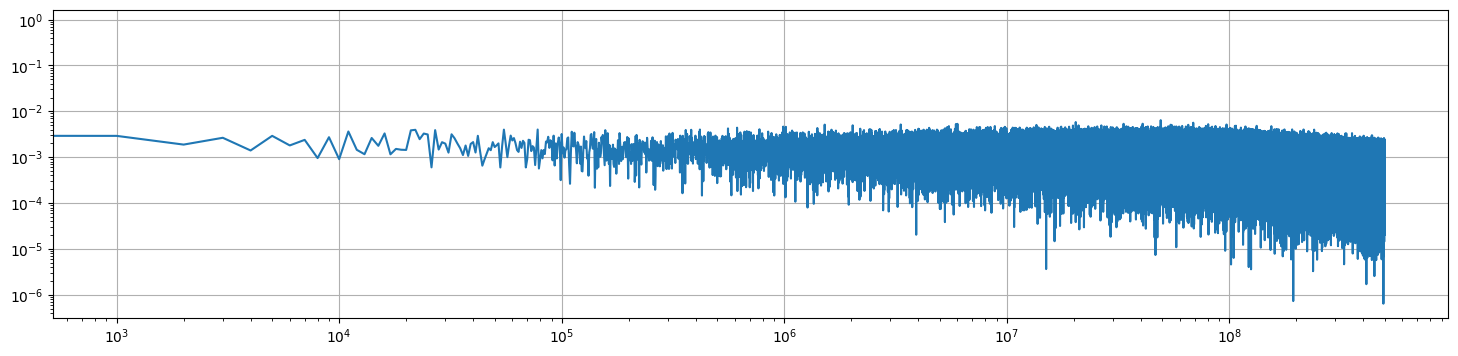

In [36]:
from scipy.fft import fft, fftfreq

N = len(sum)
T = 1e-9
yf = fft(sum)

xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(18, 4))
plt.loglog(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

## Filtering

In [10]:
from scipy.signal import butter, lfilter, freqz

In [11]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [12]:
Array_signal[6,500000]= Array_signal[6,500000] + 5

IndexError: index 500000 is out of bounds for axis 1 with size 100000

In [ ]:

# Filter requirements.
order = 1
fs = 1e9       # sample rate, Hz
cutoff = 400e6  # desired cutoff frequency of the filter, Hz


y = butter_lowpass_filter(np.sum(Array_signal, axis=0), cutoff, fs, order)

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(np.sum(Array_signal, axis=0))
plt.plot(y)


In [ ]:
np.mean(np.sum(Array_signal, axis=0))
np.mean(y)

In [ ]:
np.std(np.sum(Array_signal, axis=0))

In [ ]:
%pip install scipy